# Figures 5-6-SI: S100A4 ensemble epistasis analysis


Here we are loading in Rosetta output and assuming there is a correlation between Rosetta units and kcal/mol units. (see Kellogg et al, 2011).

## Imports

In [87]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy

# Some pretty plot defaults
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False



matplotlib.rcParams['axes.labelsize'] = 25
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 



# cwd for saving figs
cwd = os.getcwd()

## Load data from ROSETTA. 

Each line of the text file (output-cycles.txt) has 20 entries in the following order, delimited by commas, with no line breaks.  
(Spacing and line breaks here for human sanity).
```
mut_one,mut_two,

apo_mean_dG_m1,   apo_mean_dG_m2,   apo_mean_dG_m1m2,
ca_mean_dG_m1,    ca_mean_dG_m2,    ca_mean_dG_m1m2,
capep_mean_dG_m1, capep_mean_dG_m2, capep_mean_dG_m1m2,

apo_std_dG_m1,   apo_std_dG_m2,   apo_std_dG_m1m2,
ca_std_dG_m1,    ca_std_dG_m2,    ca_std_dG_m1m2,
capep_std_dG_m1, capep_std_dG_m2, capep_std_dG_m1m2
```

+ `mut_one` and `mut_two` are human-readable names of the mutations (like V72K, etc.)
+ `apo`, `ca`, and `capep` refer to the state on which the calculation was done. 
+ `mean` and `std` indicate whether this is the mean dG calcualted or the standard deviation on the set of dG calcultions. 
+ `m1`, `m2`, and `m1m2` refer to whether this is the effect of mutation 1, mutation 2, or mutation 1 and 2 together.  For most mutations, the `m1m2` value is `np.na` because the calculation was not done. 
+ energies are in ROSETTA energy units

In [6]:
directory = '/Users/manneliese/Desktop/PhD_progress/Publications/Genetics-resubmission/ensemble-epistasis-theory-newest/ensemble-epistasis-theory/ensemble-epistasis-theory/ensemble-epistasis-theory/s100a4/analyze-epistasis/'

file_with_cycles = directory + "output-cycles.txt"

def count_lines_in_file(filename):
    """
    Very quickly count the number of lines in a file.
    
    Following this discusssion:
    
    # https://stackoverflow.com/questions/9629179/python-counting-lines-in-a-huge-10gb-file-as-fast-as-possible
    """
    
    def blocks(files, size=65536):
        while True:
            b = files.read(size)
            if not b: break
            yield b

    
    with open(filename, "r",encoding="utf-8",errors='ignore') as f:
        count = sum(bl.count("\n") for bl in blocks(f))
        
    return count


num_lines = count_lines_in_file(file_with_cycles)


apo_dG_mean = np.zeros((num_lines,3),dtype=np.float)
ca_dG_mean = np.zeros((num_lines,3),dtype=np.float)
capep_dG_mean = np.zeros((num_lines,3),dtype=np.float)
 

apo_dG_std = np.zeros((num_lines,3),dtype=np.float)
ca_dG_std = np.zeros((num_lines,3),dtype=np.float)
capep_dG_std = np.zeros((num_lines,3),dtype=np.float)

muts = [[None,None] for _ in range(num_lines)]

with open(file_with_cycles) as f:
    for i, line in enumerate(f.readlines()):
        
        col = line.split(",")
        muts[i][0] = col[0]
        muts[i][1] = col[1]

        data = np.array(col[2:],dtype=np.float)
        
        apo_dG_mean[i,:] = data[0:3]
        ca_dG_mean[i,:] = data[3:6]
        capep_dG_mean[i,:] = data[6:9]

        apo_dG_std[i,:] = data[9:12]
        ca_dG_std[i,:] = data[12:15]
        capep_dG_std[i,:] = data[15:18]        
        
muts = np.array(muts,dtype=np.str)



apo_dG_copy = copy.deepcopy(apo_dG_mean)
ca_dG_copy = copy.deepcopy(ca_dG_mean)
capep_dG_copy = copy.deepcopy(capep_dG_mean)

## Define constants

In [7]:
BETA =  (1/(298*0.001985)) # energy units in kcal/mol
MU_PEP =  20 # pep chemical potential is 20 kcal/mol (brings capep stability equal to apo)
G_APO =  0 # apo form is favored 
G_CA  =    10 # ca form is destabilized by 10 kcal/mol (@ calcium Kd)
G_CAPEP =  20 # capep form destabilized by 20 kcal/mol (@ calcium Kd and peptide Kd)
MU_CA_RANGE = np.arange(-2,10.1,.1) # Calcium chemical potential range for calculations in kcal/mol
conv = 1 # no conversion to other energy units

## Define observables 

Free energy of each state is: 
$$\ G^{\circ}_{x} + \Delta G_{x,mut} + \sum \mu_{x}$$

Weight is:

$$w_{x} = e^{- G_{x} /RT}$$

We are calculating epistasis in the Boltzmann-weighted average energies of the ca and apo conformations as follows: 


$$ \langle G_{ca,apo} \rangle = -RT * \log * (e^{- \beta * (G_{apo}+ \Delta G_{x,apo}} + e^{- \beta * (G_{ca}+ \Delta G_{x,ca} - 4 * \mu_{ca})})$$ 


Assume that $ G_{apo}$ is $10$ $kcal/mol$ more stable than ca state and $20$ $kcal/mol$ more stable than ca/peptide state. 

## Functions for calculating fractional populations, peptide binding observable, and $Ca^{2+}$-dependent epistasis

In [24]:
def pops(dG_apo=0,dG_ca=0,dG_capep=0,   
         mu_ca=3.5,mu_pep=MU_PEP,                      
         G_apo=G_APO,G_ca=G_CA,G_capep=G_CAPEP,          
         beta=BETA):
    """
    Calculate the relative fraction of apo, ca, capep
    
    dG_apo: effect of mutations on apo stability
    dG_ca: effect of mutations on ca stability
    dG_capep: effect of mutations on capep stability
    G_apo: free energy of apo state
    G_ca: free energy of ca state (no ca)
    G_capep: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca: chemical potential of calcium
    beta: 1/RT (kcal/mol @ 298K)  
    
    Returns the fractional populations of apo, ca, and capep
    """
    
    w_apo =    np.exp(-(beta)*(G_apo + dG_apo))
    w_ca =     np.exp(-(beta)*(G_ca  + dG_ca - 4*mu_ca))
    w_capep =  np.exp(-(beta)*(G_capep + dG_capep - 4*mu_ca - mu_pep))
    
    Z = w_apo + w_ca + w_capep

    return w_apo/Z, w_ca/Z, w_capep/Z

def dg_obs(dG_apo=0,dG_ca=0,dG_capep=0,       # effects of mutations
           mu_ca=3.5,mu_pep=MU_PEP,                  # chemical potential of calcium and peptide
           G_apo=G_APO, G_ca=G_CA, G_capep=G_CAPEP,        # wildtype thermodynamic parameters
           beta=BETA):                           # RT
    """
    Calculate the free energy of the capep state.
    
    dG_apo: effect of mutations on apo stability
    dG_ca: effect of mutations on ca stability
    dG_capep: effect of mutations on capep stability
    G_apo: free energy of apo state
    G_ca: free energy of ca state (no ca)
    G_capep: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca: chemical potential of calcium
    beta: 1/RT (kcal/mol @ 298K)  
    
    Returns dG(apo + ca -> capep)
    """
    
    w_apo, w_ca, w_capep = pops(dG_apo,dG_ca,dG_capep,
                                mu_ca,mu_pep,
                                G_apo,G_ca,G_capep,
                                beta)
    
    return -(1/beta)*np.log(w_capep/(w_apo + w_ca))



def boltzmann(dG_apo=0,dG_ca=0,dG_capep=0,       # effects of mutations
           mu_ca=3.5,mu_pep=MU_PEP,                  # chemical potential of calcium and peptide
           G_apo=G_APO, G_ca=G_CA, G_capep=G_CAPEP,        # wildtype thermodynamic parameters
           beta=BETA):                           # RT
    """
    Calculate the boltzmann-weighted average energies of 
    apo and ca conformations
    
    dG_apo: effect of mutations on apo stability
    dG_ca: effect of mutations on ca stability
    dG_capep: effect of mutations on capep stability
    G_apo: free energy of apo state
    G_ca: free energy of ca state (no ca)
    G_capep: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca: chemical potential of calcium
    beta: 1/RT (kcal/mol @ 298K)  
    
    Returns boltzmann weighted average energies of ca and apo
    """



    return -(1/beta)*np.log((np.exp(-(beta)*(G_apo + dG_apo)) + np.exp(-(beta)*(G_ca  + dG_ca - 4*mu_ca))))




def epistasis_vs_ca(apo_dG,ca_dG,capep_dG,
                    G_apo=G_APO,G_ca=G_CA,G_capep=G_CAPEP,
                    mu_pep=MU_PEP,mu_ca_range=MU_CA_RANGE,
                    additive_in_states=True,beta=BETA):
    """
    Calculate epistasis for the system as a function of calcium concentration.
    
    apo_dG: effect of mutation 1, mutation 2, and mutation 12 on apo stability
    ca_dG: effect of mutation 1, mutation 2, and mutation 12 on ca stability
    capep_dG: effect of mutation 1, mutation 2, and mutation 12 on capep stability
    G_apo: free energy of apo state
    G_ca: free energy of ca state (no ca)
    G_capep: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca_range: chemical potential range of calcium
    additive_in_states: assume that dG terms sum within each state. If False,
                        the dG effect of the double mutant would need to 
                        have been calculated in rosetta.
    beta: 1/RT (kcal/mol @ 298 K)
    """
    
    
   

        
    # If we are assuming mutations are additive within a state, 
    # throw out the (possibly) calculated dG12 value. 
    if additive_in_states:
        apo_dG[2] = apo_dG[0] + apo_dG[1]
        ca_dG[2] = ca_dG[0] + ca_dG[1]
        capep_dG[2] = capep_dG[0] + capep_dG[1]
    
    # free energy of capep for each genotype
    wt =  boltzmann(dG_apo=0,
                 dG_ca=0,
                 dG_capep=0,                          
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 G_apo=G_apo,
                 G_ca=G_ca,
                 G_capep=G_capep,
                 beta=beta)

    m1 = boltzmann(dG_apo=apo_dG[0],
                 dG_ca=ca_dG[0],
                 dG_capep=capep_dG[0],  
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 G_apo=G_apo,
                 G_ca=G_ca,
                 G_capep=G_capep,
                 beta=beta)
    
    m2 =  boltzmann(dG_apo=apo_dG[1],
                 dG_ca=ca_dG[1],
                 dG_capep=capep_dG[1], 
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 G_apo=G_apo,
                 G_ca=G_ca,
                 G_capep=G_capep,
                 beta=beta)
    
    m12 = boltzmann(dG_apo=apo_dG[2],
                 dG_ca=ca_dG[2],
                 dG_capep=capep_dG[2],  
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 G_apo=G_apo,
                 G_ca=G_ca,
                 G_capep=G_capep,
                 beta=beta)  

    
    # magnitude of epistasis (signed)
    mag = (m12 - m2) - (m1 - wt)
    
    # Sign of mutation 1 (will be False if mutation effect has same
    # sign in both backgrounds; True if opposite signs)
    sign1 = (m12 - m2)/(m1 - wt)
    sign1 = sign1 < 0

    # Sign of mutation 2 (will be False if mutation effect has same
    # sign in both backgrounds; True if opposite signs)
    sign2 = (m12 - m1)/(m2 - wt)
    sign2 = sign2/np.abs(sign2) < 0

    return mag, sign1, sign2

# Panel 5C: Manipulation of ensemble structure energy levels with $Ca^{2+}$ and peptide

Fig 5C: Energetic effects on S100A4 ensemble when mu peptide and mu Ca2+ increase


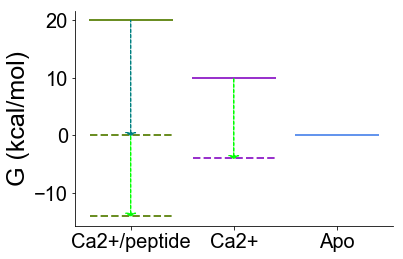

In [88]:
def plot_ensemble_levels(G_apo=G_APO,
                         G_ca=G_CA,
                         G_capep=G_CAPEP,
                         mu_ca=3.5,
                         mu_pep=MU_PEP,
                        save_fig = False):
    
    plt.figure()
    
    # x-placement for edges of conformation
    x0 = 0
    x1 = 1
    x2 = 2
    
    #plot capep
    plt.plot([x0,x0+0.8],[G_capep,G_capep],lw=2,color="olivedrab",zorder=10)
    
    #peptide addition to capep
    plt.plot([x0,x0+0.8],[G_capep-mu_pep,G_capep-mu_pep],'--',lw=2,color="olivedrab",zorder=10)
    plt.arrow((x0+0.4),G_capep,0,-mu_pep,color='teal',linestyle='--',
              length_includes_head=True,head_width=0.1,head_length=0.50,zorder=20)
    
    #calcium addition to capep
    plt.plot([x0,x0+0.8],[G_capep-mu_pep-4*mu_ca,G_capep-mu_pep-4*mu_ca],'--',lw=2,color="olivedrab",zorder=10)
    plt.arrow((x0+0.4),G_capep-mu_pep,0,-4*mu_ca,color='lime',linestyle='--',
              length_includes_head=True,head_width=0.1,head_length=0.50,zorder=20)
    
    #plot ca
    plt.plot([x1,x1+0.8],[G_ca,G_ca],lw=2,color="darkorchid",zorder=10)
    
    #calcium addition to ca
    plt.plot([x1,x1+0.8],[G_ca-4*mu_ca,G_ca-4*mu_ca],'--',lw=2,color="darkorchid",zorder=10)
    plt.arrow((x1+0.4),G_ca,0,-4*mu_ca,color='lime',linestyle='--',
              length_includes_head=True,head_width=0.1,head_length=0.50,zorder=20)
    
    #plot apo
    plt.plot([x2,x2+0.8],[G_apo,G_apo],lw=2,color="cornflowerblue",zorder=10)
    
    #general plot settings
    plt.xticks([0.4,1.4,2.4],['Ca2+/peptide','Ca2+','Apo'])
    plt.ylabel('G (kcal/mol)')
    plt.tight_layout()
    if save_fig:
        plt.savefig(cwd + '/Fig5C-ensemble-energy-levels.svg')
    
    
    
#call the function
print('Fig 5C: Energetic effects on S100A4 ensemble when mu peptide and mu Ca2+ increase')

plot_ensemble_levels(save_fig = True)

# Plot fractional population as a function of $Ca^{2+}$ concentration

Wildtype S100A4 ensemble changes as a function of mu Ca2+
What is the effect of peptide on the ensemble?


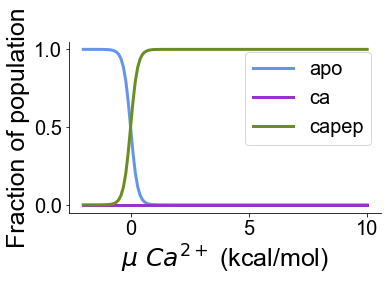

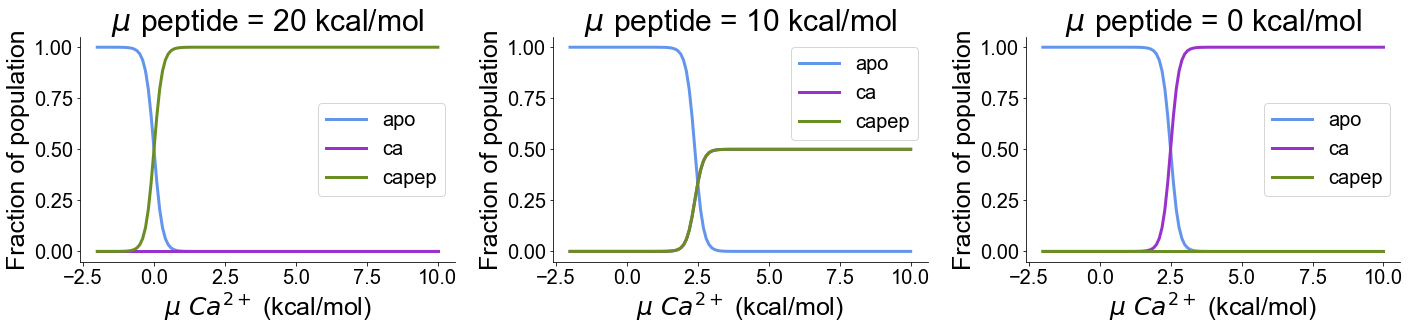

In [60]:
def pop_curves(dG_a,
               dG_c,
               dG_cp,
               g_apo = G_APO,
               g_ca = G_CA,
               g_capep = G_CAPEP,
               mu_range = MU_CA_RANGE,
               save = False):
    '''
    Plot fractional population of each state as a
    function of the negative Ca2+ chemical potential.
    dd_a: effect of mutation of apo stability
    dG_c: effect of mutation on ca stability
    dG_cp: effect of mutation on cp stability
    g_apo: free energy of apo state
    g_ca: free energy of ca state (no ca)
    g_capep: free energy of ca/pep state (no ca, no pep)
    mu_range: chemical potential range of calcium
    
    '''
    
    fig, ax = plt.subplots(1,1)
    
    #calculate fractional populations
    apo, ca, capep = pops(dG_apo=dG_a,
                      dG_ca=dG_c,
                      dG_capep=dG_cp,
                      mu_ca=mu_range,
                      mu_pep=MU_PEP,
                      beta=BETA,
                      G_apo=g_apo,
                      G_ca=g_ca,
                      G_capep=g_capep)
    
    
    
    #plot fractions for each structure
    ax.plot(mu_range,apo,lw=3,color='cornflowerblue',label="apo")
    ax.plot(mu_range,ca,lw=3,color='darkorchid',label="ca")
    ax.plot(mu_range,capep,lw=3,color='olivedrab',label="capep")
    

    #general plot settings
    ax.set_ylabel('Fraction of population')
    ax.set_xlabel("$\mu\ Ca^{2+}$ (kcal/mol)")
    ax.legend()
    plt.tight_layout()
    if save:
        fig.savefig('frac-wt.svg')
        





def pep_curves(dG_a,dG_c,dG_cp,
               g_apo = G_APO,
               g_ca = G_CA,
               g_capep = G_CAPEP,
               mu_range = MU_CA_RANGE, save = False):
    '''
    Plot fractional population of each state as a
    function of the negative Ca2+ chemical potential.
    dG_a: effect of mutation of apo stability
    dG_c: effect of mutation on ca stability
    dG_cp: effect of mutation on cp stability
    g_apo: free energy of apo state
    g_ca: free energy of ca state (no ca)
    g_capep: free energy of ca/pep state (no ca, no pep)
    mu_range: chemical potential range of calcium
    
    '''
    
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    
    peps = [20,10,0]
    
    for i in range(3):
    
        #calculate fractional populations
        apo, ca, capep = pops(dG_apo=dG_a,
                          dG_ca=dG_c,
                          dG_capep=dG_cp,
                          mu_ca=mu_range,
                          mu_pep=peps[i],
                          beta=BETA,
                          G_apo=g_apo,
                          G_ca=g_ca,
                          G_capep=g_capep)
        
        #plot fractions for each structure
        
        ## plot apo
        ax[i].plot(mu_range,
                   apo,
                   lw=3,color='cornflowerblue',label="apo")
        
        ## plot ca
        ax[i].plot(mu_range,
                   ca,
                   lw=3,color='darkorchid',label="ca")
        
        ## plot capep
        ax[i].plot(mu_range,
                   capep,
                   lw=3,color='olivedrab',label="capep")

        #general plot settings
        ax[i].set_ylabel('Fraction of population')
        ax[i].set_xlabel("$\mu\ Ca^{2+}$ (kcal/mol)")
        ax[i].set_title("$\mu\ $peptide = {} kcal/mol".format(str(peps[i])))
        ax[i].legend()
        plt.tight_layout()
        
        
        if save:
            fig.savefig('pepmanip2.pdf')
        
print("Wildtype S100A4 ensemble changes as a function of mu Ca2+")
#call the function for WT ensemble (dG_a, dG_c, and dG_cp are zero)
pop_curves(0,0,0, save = False)


print('What is the effect of peptide on the ensemble?')
pep_curves(0,0,0, save = False)

# Epistasis vs $Ca^{2+}$ chemical potential for all mutation pairs


# Takes a long time to run!

Calculate maximum epistasis for each mutation pair within $Ca^{2+}$ chemical potential range

In [61]:
#################################################################################################################
## initialize arrays
#################################################################################################################
## all_mag = epistatic magnitude as a function of mu_ca_range
## all_sign = True/False if a mutation in pair switches sign at specific mu_ca value
## all_recip = True/False if both mutations in pair switches sign at specific mu_ca value
all_mag = np.zeros((apo_dG_mean.shape[0], len(MU_CA_RANGE)),dtype=np.float)
all_sign = np.zeros((apo_dG_mean.shape[0], len(MU_CA_RANGE)),dtype=np.float)
all_recip = np.zeros((apo_dG_mean.shape[0], len(MU_CA_RANGE)),dtype=np.float)

max_mag = np.zeros(apo_dG_mean.shape[0],dtype = np.float)
max_sign = np.zeros(apo_dG_mean.shape[0], dtype = np.bool)
max_recip = np.zeros(apo_dG_mean.shape[0], dtype = np.bool)


#################################################################################################################
## loop through each mutation pair and calculate epistaasis magnitude/type
#################################################################################################################
for i in range(len(apo_dG_mean)):
    
    
    mag, sign1, sign2 = epistasis_vs_ca(apo_dG_mean[i,:],
                                        ca_dG_mean[i,:],
                                        capep_dG_mean[i,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)
    
    
    # If sign on both, reciprocal
    reciprocal = np.logical_and(sign1,sign2)

    # Sign (as a class) will be sign on one mut but *not* reciprocal
    sign = np.logical_and(np.logical_or(sign1,sign2),
                          np.logical_not(reciprocal))
    
    # Index of maximum epistasis over this [Ca] range
    max_index = np.argmax(np.abs(mag))
    max_mag[i] = mag[max_index]
    max_sign[i] = sign[max_index]
    max_recip[i] = reciprocal[max_index]
        
    ## keep track of epistasis as a function of mu Ca
    all_mag[i] = mag
    all_sign[i] = sign
    all_recip[i] = reciprocal
    
    

/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in true_divide
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in true_divide
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in true_divide


## Panel 6A: Plot fractional contributions of epistasis types based on cutoff threshold



Note: this is for maximum epistatic value over all $\mu$ $Ca^{2+}$ for each pair 

Figure 5A: Fraction of each type of epistasis as a function of cutoff


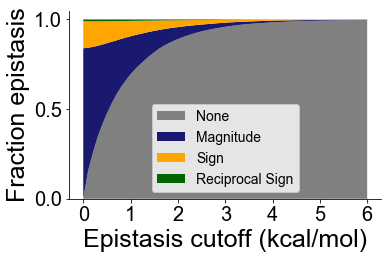

In [122]:
def plot_threshold(all_m,all_s,all_r, save_fig = False):
    '''
    Generate continuous stacked bar plot for the 
    fraction of mutation pairs composing each class 
    of epistasis as the epistatic 
    cutoff in kcal/mol is increased. 
    
    Pairs with maximum epistasis below the cutoff are
    considered to have no epistasis.
    
    Returns fx_df: dataframe with epistatic fractions
    for integer cutoff values.
    
    all_m: array with maximum epistatic magnitude 
    all_s: array with truth of sign epistasis
    all_r: array with truth of reciprocal sign epistasis
    '''
    
    ## cutoff ranges to investigate
    cutoff_range=np.arange(0,6.1,0.1)


    
    ## 
    sign_arr = np.zeros(len(cutoff_range))
    recip_arr = np.zeros(len(cutoff_range))
    mag_arr = np.zeros(len(cutoff_range))
    none_arr = np.zeros(len(cutoff_range))
    
    
    
    ## 
    s_arr = np.zeros(len(cutoff_range))
    r_arr = np.zeros(len(cutoff_range))
    m_arr = np.zeros(len(cutoff_range))
    n_arr = np.zeros(len(cutoff_range))
    
    j=0


    #calculate epistasis fractions for each cutoff
    for i, cutoff in enumerate(cutoff_range):
        
        
        ## create a mask to get mutation pairs
        ## with epistatic magnitude above cutoff value
        mask = np.abs(all_m) > cutoff

        ## figure out what % of pairs are above cutoff AND are of type = Sign
        fx_sign = np.sum(all_s[mask])/all_s.shape[0]
        sign_arr[i] = fx_sign

        ## figure out what % of pairs are above cutoff AND are of type = Reciprocal Sign
        fx_recip = np.sum(all_r[mask])/all_s.shape[0]
        recip_arr[i] = fx_recip
        
        ## figure out what % of pairs are above cutoff AND are of type = Magnitude, i.e. not sign or recip
        fx_mag = np.sum(np.logical_not(np.logical_or(all_s[mask],all_r[mask])))/all_s.shape[0]
        mag_arr[i] = fx_mag

        
        ## what % of pairs are below cutoff?
        fx_none = 1 - fx_sign - fx_recip - fx_mag
        none_arr[i] = fx_none
   

        ## keep track of fractions of pairs sign/recip/magnitude/none
        if cutoff in cutoff_range:
            s_arr[j] = fx_sign
            r_arr[j] = fx_recip
            m_arr[j] = fx_mag
            n_arr[j] = fx_none
            j += 1
            
    ## output fraction of pairs as a function of cutoff 
    ## as a dataframe for further analysis
    fx_df = pd.DataFrame({'Cutoff kT':cutoff_range,'Fx_none':n_arr,
                          'Fx_mag':m_arr,'Fx_sign':s_arr,'Fx_recip':r_arr})
    
    plt.stackplot(cutoff_range,none_arr,mag_arr,sign_arr,recip_arr,
                  labels=['None','Magnitude','Sign','Reciprocal Sign'],
                  colors=['grey','midnightblue','orange','darkgreen'])
    
    plt.ylabel('Fraction epistasis')
    plt.xlabel('Epistasis cutoff (kcal/mol)')
    plt.xticks(np.arange(0,6.1,1))
    plt.legend(loc='lower center',fontsize='x-small')
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(cwd + '/Fig-6A-cutoff-curves-kcal.svg')
    

    return fx_df



################################################################################################################
## Call the function to plot epistasis type as a function of cutoff
#################################################################################################################
print('Figure 5A: Fraction of each type of epistasis as a function of cutoff')
fx = plot_threshold(all_m=max_mag, 
                    all_s = max_sign,
               all_r = max_recip,
                    save_fig = True)

## Epistatic magnitude statistics:


+ How many pairs have an epistatic magnitude of at least 0.6 kcal/mol? 


+ How many pairs exhibit strong epistasis (i.e. above 2 kcal/mol)?

In [95]:
#################################################################################################################
## how many pairs are at least 0.6 kcal/mol (1 kT, thermal fluctuation)
#################################################################################################################

cut = 0.6 # in kcal/mol
filtered_1 = fx[fx['Cutoff kT'] >= cut]
print('fraction above ' + str(cut) + ' kcal/mol: ', 1-filtered_1.iloc[0,1], '\n')
print('fraction of magnitude pairs at ' + str(cut) + ' kcal/mol: ', filtered_1.iloc[0,2])
print('fraction of sign pairs at ' + str(cut) + ' kcal/mol: ', filtered_1.iloc[0,3])
print('fraction of reciprocal sign pairs at ' + str(cut) + ' kcal/mol: ', filtered_1.iloc[0,4], '\n', '\n')

#################################################################################################################
## how many pairs are above 2 kcal/mol?
#################################################################################################################

high_cut = 2 # in kcal/mol
high_cutoff = high_cut 
filtered_2 = fx[fx['Cutoff kT'] >= high_cutoff]
print('fraction above ' + str(high_cut) + ' kcal/mol: ', 1-filtered_2.iloc[0,1])

fraction above 0.6 kcal/mol:  0.467851086887904 

fraction of magnitude pairs at 0.6 kcal/mol:  0.34359616327752196
fraction of sign pairs at 0.6 kcal/mol:  0.11483614869647131
fraction of reciprocal sign pairs at 0.6 kcal/mol:  0.009418774913910783 
 

fraction above 2 kcal/mol:  0.10931778724643404


# Switching statistics and plotting epistasis magnitude/type for selected mutations


## Calculate epistasis type switching stats and keep track of type as a fxn of mu_ca

# Takes a long time to run!

In [96]:
#################################################################################################################
## use indices identified in the max epistatic magnitude cell that were above 0.6 kcal/ mol to 
## identify pairs to analyze epistasis as a function of Ca2+
#################################################################################################################
mask = np.abs(max_mag) >= 0.6
above_sign = all_sign[mask]
above_recip = all_recip[mask]
above_mag = all_mag[mask]


### if a mutation pair only has 1 unique element in the epistasis type array 
### that means it does not switch epistasis types as mu_ca increases
## if it has > 1 unique element, it does switch epistasis types

# initialize empty epistasis type array
epi_arr = np.zeros(above_sign.shape)


## loop through mutation pairs
for pair in range(len(above_sign)):
    
    signs = above_sign[pair]
    recips = above_recip[pair]
    mags = above_mag[pair]
    
    ## loop through each mu_ca epistasis value 
    for val in range(len(signs)):
        
        ## sign_val = 0/1 if false/true (i.e. is it sign or not)
        ## recip_val = 0/1 if false/true (i.e. is it reciprocal or not)
        ## if neither sign/recip, magnitude
        sign_val = signs[val]
        recip_val = recips[val]
        mags_val = mags[val]
        
        
        
        ## if magnitude is below 1 kT (0.6 kcal/mol), input NaN
        if np.abs(mags_val) < 0.6:
            epi_arr[pair,val] = np.nan
        
  
        elif sign_val == 0 and recip_val == 0:
            epi_arr[pair,val] = 1 
            # 1 = magnitude
            
        elif sign_val == 1: 

            epi_arr[pair,val] = 2
            # 2 = sign
            
        elif recip_val == 1:
            epi_arr[pair,val] = 3
            # 3 = reciprocal sign
            
        else:
            print('weird')
            epi_arr[pair,val] = np.nan
            # not sign, magnitude or reciprocal--weird
            
#################################################################################################################
## calculate switching frequency amongst pairs with magnitude > 0.6 kcal/mol
#################################################################################################################
## no switch counter
no_switch = 0
## switch
switch = 0
# all pairs
all_pairs = 0

for j in range(len(epi_arr)):
    
    entry = epi_arr[j]

    # remove nans (i.e. epistasis magnitude values < 0.6 kcal/mol)
    entry = entry[np.logical_not(np.isnan(entry))]
    all_pairs += 1
    
    ## if only one unique element: no switching
    if len(np.unique(entry)) == 1:
        no_switch +=1
    ## if more than one, epistais type switches
    elif len(np.unique(entry)) > 1:
        switch += 1
    ## if something else is happening, weird!
    else:
        print('weird')
    
    
#################################################################################################################
## print statistics: how many switch epistasis type? how many don't?
#################################################################################################################
print('Fraction of epistatic pairs that do not switch: ', no_switch/all_pairs)
print('Fraction of epistatic pairs that do switch: ', switch/all_pairs)

            
            


Fraction of epistatic pairs that do not switch:  0.6137222895213883
Fraction of epistatic pairs that do switch:  0.3862777104786117


## Panel 6B: Grab epistasis magnitude/type as a fxn of mu_ca_range and plot for the following pairs:


+ M85K: apo buried charge, ca exposed charge
+ F145R: apo exposed charge, ca buried charge
+ F78A: apo exposed hole, ca buried hole
+ L109I: apo no change, ca no change

Fig 6B: epistasis as a function of mu Ca


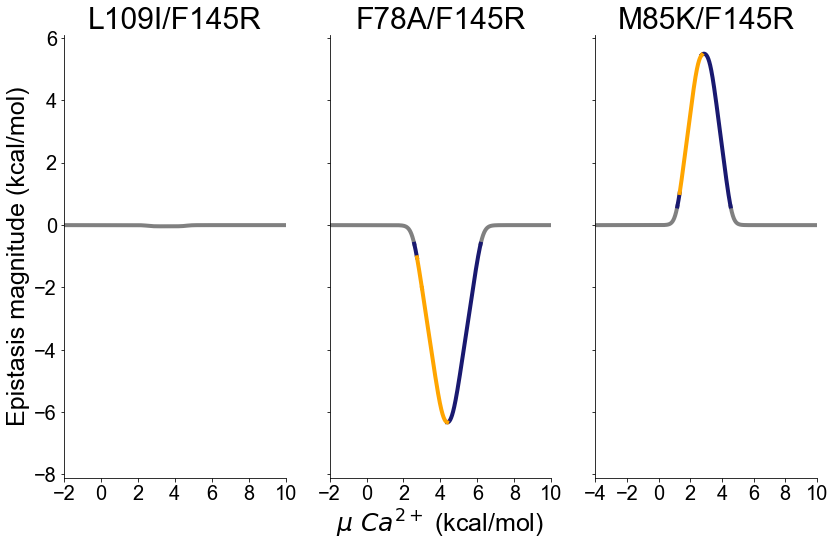

In [120]:
#################################################################################################################
# plotting epistasis magnitude and type as a function of mu_ca in kcal/mol
# 1) grab magnitude as a fxn of mu_ca from all_mag array for specific mutation pairs
# 2) grab type as a fxn of mu_ca from epi_arr for specific mutation pairs
# 3) plot!
#################################################################################################################

## need a finer range of Ca2+ for pretty plotting
mu_range = np.arange(-5,10.5,0.00001) # in kT

# Sign: F145R + M85K (opposite directions equal magnitude)
s_idx = 3652201

# Magnitude: F145R + F78A (diff mag but same direction)
m_idx = 4876241

# None: F145R + L109I
n_idx = 3983508


indexes = [s_idx, m_idx, n_idx]

mag_dict = {}
sign_dict = {}
recip_dict = {}
for idx in indexes:
    

    # calculate epistasis as fxn of mu Ca
    mag,sign1,sign2 = epistasis_vs_ca(apo_dG_mean[idx,:],ca_dG_mean[idx,:],capep_dG_mean[idx,:],
                                          G_apo=G_APO,G_ca=G_CA,G_capep=G_CAPEP,
                                          mu_pep=MU_PEP,mu_ca_range=mu_range,
                                          additive_in_states=True,beta=BETA) 
    
    
    # If sign on both, reciprocal
    reciprocal = np.logical_and(sign1,sign2)

    # Sign (as a class) will be sign on one mut but *not* reciprocal
    sign = np.logical_and(np.logical_or(sign1,sign2),
                          np.logical_not(reciprocal))
    
    mag_dict[idx] = mag
    sign_dict[idx] = sign
    recip_dict[idx] = reciprocal

#################################################################################################################
## break down into types as a function of Ca2+
#################################################################################################################    
## gather epistasis type as a fxn of ca2+ data  
ep_dict = {}
for idx in mag_dict.keys():
    
    signs = sign_dict[idx]
 
    recips = recip_dict[idx]
    mags = mag_dict[idx]
    epi_list = []
    for val in range(len(signs)):
        
        mag_val = mags[val]
        sign_val = signs[val]
        recip_val = recips[val]

        if np.abs(mag_val) < 0.6:
            epi_list.append(0)
            # 0 = not epistatic (i.e. below 0.6 kcal/mol cutoff)

    
        elif not sign_val and not recip_val:
            epi_list.append(1) 
            # 1 = magnitude
            
        elif sign_val: 
            epi_list.append(2)
            # 2 = sign
            
        elif recip_val:
            epi_list.append(3)
            # 3 = reciprocal sign
            
        else:
            print('weird')
            epi_list.append(np.nan)
            # not sign, magnitude or reciprocal--weird
            
    ep_dict[idx] = epi_list
            


## grab epistasis type as a function of mu_ca_range for each pair        
s_epi_type = np.array(ep_dict[s_idx])
m_epi_type = np.array(ep_dict[m_idx])
n_epi_type = np.array(ep_dict[n_idx])


## grab epistasis magnitude as a function of mu_ca_range for each pair
s_mag = np.array(mag_dict[s_idx])
m_mag = np.array(mag_dict[m_idx])
n_mag = np.array(mag_dict[n_idx])


#################################################################################################################
# plotting epistasis magnitude and type as a function of mu_ca in kcal/mol
#################################################################################################################
print('Fig 6B: epistasis as a function of mu Ca')


# prepare for plotting
color_dict ={2.0: 'orange',1.0: 'midnightblue',0.0: 'grey', 3.0: 'darkgreen'}

## grab no epistasis
s_grey = s_mag[s_epi_type == 0]
s_mu_grey = mu_range[s_epi_type == 0]
m_grey = m_mag[m_epi_type == 0]
m_mu_grey = mu_range[m_epi_type == 0]

## grab sign
s_orange = s_mag[s_epi_type == 2]
s_mu_orange = mu_range[s_epi_type == 2]
m_orange = m_mag[m_epi_type == 2]
m_mu_orange = mu_range[m_epi_type == 2]

## grab magnitude
s_blue = s_mag[s_epi_type == 1]
s_mu_blue = mu_range[s_epi_type == 1]
m_blue = m_mag[m_epi_type == 1]
m_mu_blue = mu_range[m_epi_type == 1]

## grab reciprocal 
s_green = s_mag[s_epi_type == 3]
s_mu_green = mu_range[s_epi_type == 3]
m_green = m_mag[m_epi_type == 3]
m_mu_green = mu_range[m_epi_type == 3]




#################################################################################################################
# plot
#################################################################################################################
save = True
fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize = (12,8))

## plot L109I/F145R data
ax1.plot(mu_range, n_mag, color = color_dict[0],
         label = 'L109I/F145R', linewidth = 4)


## plot F78A/F145R no epistasis data
ax2.plot(m_mu_grey[m_mu_grey < 3], m_grey[m_mu_grey < 3], color = color_dict[0.0],
         label = 'M85K/F145R', linewidth = 4)
ax2.plot(m_mu_grey[m_mu_grey > 3], m_grey[m_mu_grey > 3],  color = color_dict[0.0],
         linewidth = 4)

## plot F78A/F145R magnitude data
ax2.plot(m_mu_blue[m_mu_blue < 4], m_blue[m_mu_blue < 4],   color = color_dict[1.0],
         linewidth = 4)
ax2.plot(m_mu_blue[m_mu_blue > 4], m_blue[m_mu_blue > 4],  color = color_dict[1.0],
         linewidth = 4)

## plot F78A/F145R sign epistasis data
ax2.plot(m_mu_orange[m_mu_orange > 3], m_orange[m_mu_orange > 3],  color = color_dict[2.0],
         linewidth = 4)
ax2.plot(m_mu_orange[m_mu_orange < 3], m_orange[m_mu_orange < 3],  color = color_dict[2.0],
         linewidth = 4)

## plot F78A/F145R reciprocal sign epistasis data
ax2.plot(m_mu_green, m_green, color = color_dict[3.0],
         linewidth = 4)



## plot M85K/F145R no epistasis data
ax3.plot(s_mu_grey[s_mu_grey < 3], s_grey[s_mu_grey < 3], color = color_dict[0.0],
         label = 'M85K/F145R', linewidth = 4)
ax3.plot(s_mu_grey[s_mu_grey > 3], s_grey[s_mu_grey > 3],  color = color_dict[0.0],
         linewidth = 4)

## plot M85K/F145R magnitude data
ax3.plot(s_mu_blue[s_mu_blue < 2.5], s_blue[s_mu_blue < 2.5],   color = color_dict[1.0],
         linewidth = 4)
ax3.plot(s_mu_blue[s_mu_blue > 2.5], s_blue[s_mu_blue > 2.5],  color = color_dict[1.0],
       linewidth = 4)

## plot M85K/F145R sign epistasis data
ax3.plot(s_mu_orange[s_mu_orange > 3], s_orange[s_mu_orange > 3],  color = color_dict[2.0],
         linewidth = 4)
ax3.plot(s_mu_orange[s_mu_orange < 3], s_orange[s_mu_orange < 3],  color = color_dict[2.0],
         linewidth = 4)

## plot M85K/F145R reciprocal sign epistasis data
ax3.plot(s_mu_green, s_green, color = color_dict[3.0],
         linewidth = 4)







## define titles
ax1.set_title('L109I/F145R')
ax2.set_title('F78A/F145R')
ax3.set_title('M85K/F145R')
## define axis labels
ax1.set_ylabel("Epistasis magnitude (kcal/mol)")
ax2.set_xlabel("$\mu\ Ca^{2+}$ (kcal/mol)")
# define x and y limits
ax1.set_xlim(-2,10)
plt.ylim(-8.1,6.1)
plt.xticks(np.arange(-4,11,2))
plt.tight_layout()
save = True
if save:
    plt.savefig(cwd + '/Fig-6B-stacked.pdf')
plt.show()

# Panel 6D-I: Energy diagrams for select mutations


### Grab data for selected mutations at mu Ca = 3.5 kcal/mol for energy diagram plotting

+ M85K: apo buried charge, ca exposed charge
+ F145R: apo exposed charge, ca buried charge
+ F78A: apo exposed hole, ca buried hole
+ L109I: apo no change, ca no change


In [123]:
def find_ca_index(desired_ca_value = 3.5, mu_ca_range = MU_CA_RANGE):
    for i in range(len(mu_ca_range)):
        ca = mu_ca_range[i]
        upper = desired_ca_value + 0.01
        lower = desired_ca_value - 0.01
        if ca > lower and ca < upper:
            return i
    



## index corresponding to mu_ca = 3.5 kcal/mol in all_mag array
index_3p5 = find_ca_index()

## calculate magnitude of epistasis at mu_ca = 3.5 kcal/mol
## keep track of type of epistasis (sign/reciprocal sign/magnitude)
all_mag_select = all_mag[[s_idx, m_idx, n_idx],index_3p5]
all_sign_select = all_sign[[s_idx, m_idx, n_idx],index_3p5]
all_recip_select = all_recip[[s_idx, m_idx, n_idx],index_3p5]

#################################################################################################################
# generate dataframe of epistasis magnitude for selected mutants 
# at mu_ca = 3.5 kcal/mol 
#################################################################################################################

df = pd.DataFrame({'m1':muts[[s_idx, m_idx, n_idx],0],'m2':muts[[s_idx, m_idx, n_idx],1],
                   'apo_m1':apo_dG_mean[[s_idx, m_idx, n_idx],0],'apo_m2':apo_dG_mean[[s_idx, m_idx, n_idx],1],
                   'ca_m1':ca_dG_mean[[s_idx, m_idx, n_idx],0],'ca_m2':ca_dG_mean[[s_idx, m_idx, n_idx],1],
                   'capep_m1':capep_dG_mean[[s_idx, m_idx, n_idx],0],'capep_m2':capep_dG_mean[[s_idx, m_idx, n_idx],1],
                   'all_mag_sel':all_mag_select,'all_sign_sel':all_sign_select,'all_recip_sel':all_recip_select})




ex1_df = df.reset_index()
ex1_df.loc[:,"index"] = 0


ex_df = ex1_df[['index','m2','m1','apo_m2','apo_m1',
                'ca_m2','ca_m1','capep_m2','capep_m1',
                'all_mag_sel','all_sign_sel','all_recip_sel']]

# get values from ex_df
ex_arr = ex_df.values

name_arr = ex_arr[:,[1,2]]
apo_dg_arr = ex_arr[:,[3,4,0]]
ca_dg_arr = ex_arr[:,[5,6,0]]
capep_dg_arr = ex_arr[:,[7,8,0]]
type_arr = np.array(['Sign','Magnitude','None'])

print(ex_df)
def _plot_states_ca(G_apo=0,G_ca=0,                        
                    dG_apo=None,dG_ca=None,         
                    observable=0,x_location=0,
                    arrow_colors=None):                              
    """
    Draw conformation energies and effects of mutations for a given genotype.
    
    G_apo: stability of apo before mutation
    G_ca: stability of ca before mutation
    dG_apo: effect of mutations to apo structure.  
           If None, no mutations.
           If float, single mutation (one arrow).
           If list of floats, multiple mutations (each with own arrow)
    dG_ca: effect of mutations to ca.  (Same syntax as dG_apo).
    observable: observable dGcapep
    x_location: where to draw states on total plot.
    arrow_colors: color to draw each arrow.
                  If None, all arrows black.
                  Otherwise, must be a list of colors, in order.  Arrows are
                  plotted in order dG_apo, then dG_ca.   
    """
    #################################################################################################################
    # x-placement for edges of genotypes
    #################################################################################################################
    x0 = 0
    x1 = 2
    x2 = 2.5
    x3 = 4.5
    
    #################################################################################################################
    # If dG_ca specified, add dashed line for dG_ca
    #################################################################################################################
    if dG_ca is None:
        dG_ca = 0
    else:        
        plt.plot([x0+x_location,x1+x_location],[G_ca,
                                                G_ca],"--",
                 lw=2,color="darkorchid",zorder=10)
    #################################################################################################################
    # If dG_apo is specified, add dashed line for dG_apo
    #################################################################################################################
    if dG_apo is None:
        dG_apo = 0
        
    else:        

        plt.plot([x2+x_location,x3+x_location],[G_apo,
                                                G_apo],"--",
                 lw=2,color="cornflowerblue",zorder=10)
    
    #################################################################################################################
    # If dG_ca is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    #################################################################################################################
    try:
        len(dG_ca)
        total_dG_ca = sum(dG_ca)
    except TypeError:
        total_dG_ca = dG_ca
        dG_ca = [dG_ca,]
    
    #################################################################################################################
    # If dG_apo is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    #################################################################################################################
    try:
        len(dG_apo)
        total_dG_apo = sum(dG_apo)
    except TypeError:
        total_dG_apo = dG_apo
        dG_apo = [dG_apo,]
    
    
    #################################################################################################################
    # Plot energy levels
    #################################################################################################################
    plt.plot([x0+x_location,x1+x_location],[G_ca  + total_dG_ca,
                                            G_ca  + total_dG_ca],
             lw=2,color="darkorchid",zorder=10)
    plt.plot([x2+x_location,x3+x_location],[G_apo + total_dG_apo,
                                            G_apo + total_dG_apo],
             lw=2,color="cornflowerblue",zorder=10)
    
    
    #################################################################################################################
    # Plot observable
    #################################################################################################################
    plt.plot([x0+x_location,x3+x_location],[observable,
                                            observable],lw=4,color="black",zorder=0)
    
    
    #################################################################################################################
    # Count through arrow colors
    #################################################################################################################
    
    color_counter = 0
        
    current = G_ca
    for counter, ca_arrow in enumerate(dG_ca):
        
        # If this dG is 0, do not draw an arrow
        if ca_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x0 + (x1 - x0)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = ca_arrow/np.abs(ca_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        
        # Draw arrow
        plt.arrow(x,conv*current,0,ca_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        # Update counters
        current = current + ca_arrow
        color_counter += 1
        
    #################################################################################################################
    #################################################################################################################
    
    current = G_apo
    for counter, apo_arrow in enumerate(dG_apo):
        
        # If this dG is 0, do not draw an arrow
        if apo_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x2 + (x3 - x2)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = apo_arrow/np.abs(apo_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        
        # Draw arrow
        plt.arrow(x,conv*current,0,apo_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        # Update counters
        current = current + apo_arrow
        color_counter += 1
        
    plt.ylabel('G (kcal/mol)')

    
def plot_state_cycle_ca(index,apo_dG,ca_dG,capep_dG,
                        G_apo,G_ca,G_capep,
                        mu_pep,mu_ca,
                        additive_in_states=True,beta=BETA,
                        ylim=(-12,18)):
    """
    Calculate epistasis for the system as a function of calcium concentration.
    index = 
    apo_dG: effect of mutation 1, mutation 2, and mutation 12 on apo stability
    ca_dG: effect of mutation 1, mutation 2, and mutation 12 on ca stability
    capep_dG: effect of mutation 1, mutation 2, and mutation 12 on capep stability
    apo_G: free energy of apo state
    ca_G: free energy of ca state (no ca)
    capep_G: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca_range: chemical potential range of calcium
    additive_in_states: assume that dG terms sum within each state. If False,
                        the dG effect of the double mutant would need to 
                        have been calculated in rosetta.
    beta: 1/RT
    """    
    
    if additive_in_states:
        apo_dG[2] = apo_dG[0] + apo_dG[1]
        ca_dG[2] = ca_dG[0] + ca_dG[1]
        capep_dG[2] = capep_dG[0] + capep_dG[1]
    
    # boltzmann weighted avg energies of apo and ca 
    ab =  boltzmann(dG_apo=0,
                 dG_ca=0,
                 dG_capep=0,                          
                 mu_ca=mu_ca,
                 mu_pep=mu_pep,
                 G_apo=G_apo,
                 G_ca=G_ca,
                 G_capep=G_capep,
                 beta=beta)
    
    Ab =  boltzmann(dG_apo=apo_dG[0],
                 dG_ca=ca_dG[0],
                 dG_capep=capep_dG[0],  
                 mu_ca=mu_ca,
                 mu_pep=mu_pep,
                 G_apo=G_apo,
                 G_ca=G_ca,
                 G_capep=G_capep,
                 beta=beta)
    
    aB =  boltzmann(dG_apo=apo_dG[1],
                 dG_ca=ca_dG[1],
                 dG_capep=capep_dG[1], 
                 mu_ca=mu_ca,
                 mu_pep=mu_pep,
                 G_apo=G_apo,
                 G_ca=G_ca,
                 G_capep=G_capep,
                 beta=beta)
    
    AB = boltzmann(dG_apo=apo_dG[2],
                 dG_ca=ca_dG[2],
                 dG_capep=capep_dG[2],  
                 mu_ca=mu_ca,
                 mu_pep=mu_pep,
                 G_apo=G_apo,
                 G_ca=G_ca,
                 G_capep=G_capep,
                 beta=beta)  
    
    
    G_j = G_apo
    G_k = (G_ca - 4*mu_ca)
    dG_Aj, dG_Bj = apo_dG[0:2]
    dG_Ak, dG_Bk = ca_dG[0:2]

    # Plot states for each genotype, offseting by x_location for each one
    _plot_states_ca(G_j,G_k,observable=ab,x_location=0)
    _plot_states_ca(G_j,G_k,[dG_Aj],[dG_Ak],observable=Ab,x_location=6,arrow_colors=["orange","orange"])
    _plot_states_ca(G_j,G_k,[dG_Bj],[dG_Bk],observable=aB,x_location=12,arrow_colors=["green","green"])
    _plot_states_ca(G_j,G_k,[dG_Bj,dG_Aj],[dG_Bk,dG_Ak],observable=AB,x_location=18,
                    arrow_colors=["green","orange","green","orange"])
    
    # print relative populations
    print('pop-ab, j: ' , np.exp(-G_j)/(np.exp(-G_j) + np.exp(-G_k)), '\n')
    print('pop-ab, k: ' , np.exp(-G_k)/(np.exp(-G_j) + np.exp(-G_k)), '\n')
    
    print('pop-Ab, j: ' , np.exp(-(G_j + dG_Aj))/(np.exp(-(G_j + dG_Aj)) + np.exp(-(G_k + dG_Ak))), '\n')
    print('pop-Ab, k: ' , np.exp(-(G_k + dG_Ak))/(np.exp(-(G_j + dG_Aj)) + np.exp(-(G_k + dG_Ak))), '\n')
    
    print('pop-aB, j: ' , np.exp(-(G_j + dG_Bj))/(np.exp(-(G_j + dG_Bj)) + np.exp(-(G_k + dG_Bk))), '\n')
    print('pop-aB, k: ' , np.exp(-(G_k + dG_Bk))/(np.exp(-(G_j + dG_Bj)) + np.exp(-(G_k + dG_Bk))), '\n')

    print('pop-AB, j: ' , np.exp(-(G_j + dG_Aj + dG_Bj))/(np.exp(-(G_j + dG_Aj + dG_Bj)) + np.exp(-(G_k + dG_Ak +  dG_Bk))), '\n')
    print('pop-AB, k: ' , np.exp(-(G_k + dG_Ak + dG_Bk))/(np.exp(-(G_j + dG_Aj + dG_Bj)) + np.exp(-(G_k + dG_Ak +  dG_Bk))), '\n', '\n')

    
    
    
    # Print epistasis
    print("Epistasis:",(AB-aB)-(Ab-ab))
    
    plt.ylim(ylim)
    plt.xticks([2,8,14,20],['ab','Ab','aB','AB'])

    plt.yticks(np.arange(-12,18,4))
    return None

def ex_plot(index, figure=None,MU_CA_E=3.5):
    '''
    Plot energy diagrams for mutations at indicated index in 
    the ex_df dataframe (0:sign, 1:magnitude, 2:no epistasis)

    Ca2+ chemical potential is set at 3.5 kT.

    index: position in ex_df dataframe    
    '''
    
    m1,m2 = name_arr[index,:]
    print('A: {}, B: {}'.format(m1,m2))   
    
    #create energy diagrams at mu ca = 3.5 kcal/mol
    plot_state_cycle_ca(index,apo_dg_arr[index,:],ca_dg_arr[index,:],capep_dg_arr[index,:],
                        G_apo=G_APO,G_ca=G_CA,G_capep=G_CAPEP,
                        mu_pep=MU_PEP,mu_ca=MU_CA_E)
    
    if figure != None:
        plt.savefig(cwd + '/' + figure + '.pdf')
    
    
    return None

   index     m2     m1  apo_m2  apo_m1  ca_m2   ca_m1  capep_m2  capep_m1  \
0      0   M85K  F145R  -1.032   7.809  7.495   2.213     4.487     5.786   
1      0   F78A  F145R  -1.032   4.761  7.495  11.287     4.487    13.262   
2      0  L109I  F145R  -1.032   0.021  7.495   0.059     4.487     0.274   

   all_mag_sel  all_sign_sel  all_recip_sel  
0     4.436706           0.0            0.0  
1    -3.992192           1.0            0.0  
2    -0.037937           0.0            0.0  


Figure 6D-E: No epistasis––F145R/L109I
A: L109I, B: F145R
pop-ab, j:  0.01798620996209156 

pop-ab, k:  0.9820137900379085 

pop-Ab, j:  0.9893026049828827 

pop-Ab, k:  0.010697395017117337 

pop-aB, j:  0.01866983211930766 

pop-aB, k:  0.9813301678806923 

pop-AB, j:  0.9896973699278044 

pop-AB, k:  0.01030263007219559 
 

Epistasis: -0.037937194624813486


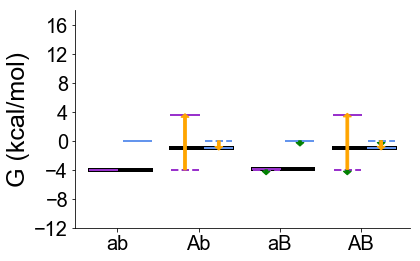

In [124]:
print('Figure 6D-E: No epistasis––F145R/L109I')
ex_plot(2, figure = 'fig-6d-e-no-epistasis')



Figure 6F: sign epistasis––F145R/F78A
A: F78A, B: F145R
pop-ab, j:  0.01798620996209156 

pop-ab, k:  0.9820137900379085 

pop-Ab, j:  0.9893026049828827 

pop-Ab, k:  0.010697395017117337 

pop-aB, j:  0.9259445352764824 

pop-aB, k:  0.07405546472351762 

pop-AB, j:  0.9999841606916837 

pop-AB, k:  1.5839308316266962e-05 
 

Epistasis: -3.9921921404277834


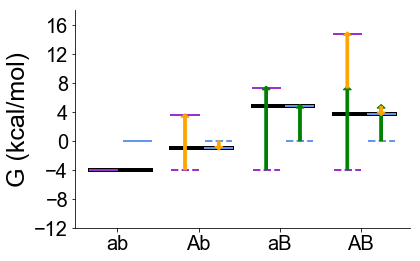

In [125]:
print('Figure 6F: sign epistasis––F145R/F78A')
ex_plot(1, figure = 'fig-6f-sign-epistasis')



Figure 6G: magnitude epistasis––F145R/M85K
A: M85K, B: F145R
pop-ab, j:  0.01798620996209156 

pop-ab, k:  0.9820137900379085 

pop-Ab, j:  0.9893026049828827 

pop-Ab, k:  0.010697395017117337 

pop-aB, j:  6.799557027790273e-05 

pop-aB, k:  0.9999320044297222 

pop-AB, j:  0.2555933030323866 

pop-AB, k:  0.7444066969676133 
 

Epistasis: 4.436706461929167


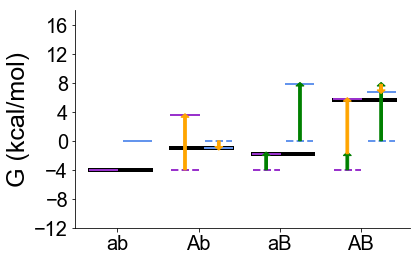

In [126]:
print('Figure 6G: magnitude epistasis––F145R/M85K')
ex_plot(0, figure = 'fig-6g-magnitude-epistasis')

Figure 6H-I: sign epistasis at mu ca = 2.2 kcal/mol––F145R/M85K
A: M85K, B: F145R
pop-ab, j:  0.768524783499015 

pop-ab, k:  0.231475216500985 

pop-Ab, j:  0.999940352579197 

pop-Ab, k:  5.964742080292006e-05 

pop-aB, j:  0.012176453972841596 

pop-aB, k:  0.9878235460271585 

pop-AB, j:  0.9841872562713879 

pop-AB, k:  0.015812743728612133 
 

Epistasis: 4.322714484080194


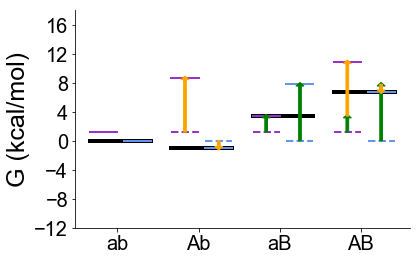

In [111]:
print('Figure 6H-I: sign epistasis at mu ca = 2.2 kcal/mol––F145R/M85K')
mus = MU_CA_RANGE[find_ca_index(2.2, MU_CA_RANGE)]
ex_plot(0, MU_CA_E = mus, figure = 'fig-6h-i-sign-epistasis')

# How much excess epistasis is there when we relax the "additive-within-states" assumption?

# Takes a long time to run!

In [137]:
## locate mutation pairs where mut12_dG value is not NaN
mut12_indices = []
for i in range(len(apo_dG_copy)):
    vals = apo_dG_copy[i]
    
    if np.isnan(vals[2]):
        pass
    else: 
        mut12_indices.append(i)
        
print('# of pairs in dataset with ROSETTA calculated mut12 value: ', len(mut12_indices))



#################################################################################################################
## find the min/max mut12 values from rosetta dataset 
## find mean/std of all values
## do this across apo, ca, and capep conformations
#################################################################################################################


all_mut12 = np.concatenate((apo_dG_copy[mut12_indices,2], ca_dG_copy[mut12_indices,2], capep_dG_copy[mut12_indices,2]))


print('mean mut12 value: ', np.mean(all_mut12))
print('std dev mut12 value: ', np.std(all_mut12))

# of pairs in dataset with ROSETTA calculated mut12 value:  344
mean mut12 value:  9.345311046511627
std dev mut12 value:  9.810125225158384


In [114]:
#################################################################################################################
## identify pairs of mutations that have a m12 value (~350 out of 5.6 million pairs)
## calculate epistasis as a function of mu_ca, setting additive_in_states = False and = True
## compare the difference in the magnitude of epistasis between the relaxed/additive datasets
#################################################################################################################

## locate mutation pairs where mut12_dG value is not NaN
mut12_indices = []
for i in range(len(apo_dG_copy)):
    vals = apo_dG_copy[i]
    
    if np.isnan(vals[2]):
        pass
    else: 
        mut12_indices.append(i)
        
print('# of pairs in dataset with ROSETTA calculated mut12 value: ', len(mut12_indices))

## make array for additive assumption
apo_dG_add = apo_dG_copy[mut12_indices]
ca_dG_add = ca_dG_copy[mut12_indices]
capep_dG_add = capep_dG_copy[mut12_indices]

## make array for not additive assumption
apo_dG_not = copy.deepcopy(apo_dG_add)
ca_dG_not = copy.deepcopy(ca_dG_add)
capep_dG_not = copy.deepcopy(capep_dG_add)

## grab mutation identities for pairs with mut12 value
muts1 = muts[mut12_indices][:,0]
muts2 = muts[mut12_indices][:,1]


#################################################################################################################
## Calculate maximum epistatic magnitude with/without additive assumption
#################################################################################################################
## initialize arrays
## mag_add = maximum epistasis magnitude with additive assumption
## mag_not = maximum epistasis magnitude without additive assumption
mag_add = np.zeros(len(apo_dG_add), dtype = np.float)
mag_not = np.zeros(len(apo_dG_add), dtype = np.float)
for i in range(len(apo_dG_add)):
    #################################################################################################################
    ## calculate with additive assumption
    #################################################################################################################

    mag_a, sign1_a, sign2_a = epistasis_vs_ca(apo_dG_add[i,:],
                                        ca_dG_add[i,:],
                                        capep_dG_add[i,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)
    # Index of maximum epistasis over this [Ca] range
    max_index = np.argmax(np.abs(mag_a))
    mag_add[i] = mag_a[max_index]
        
        
    #################################################################################################################
    ## calculate without additive assumption
    #################################################################################################################
    mag_n, sign1_n, sign2_n = epistasis_vs_ca(apo_dG_not[i,:],
                                        ca_dG_not[i,:],
                                        capep_dG_not[i,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=False,
                                        beta=BETA)
    # Index of maximum epistasis over this [Ca] range
    max_index = np.argmax(np.abs(mag_n))
    mag_not[i] = mag_n[max_index]
    
    
    
    

#################################################################################################################
## create a dataframe for all epistasis 
#################################################################################################################

## make a dataframe with all info
df12 = pd.DataFrame({'mut1': muts1, 'mut2': muts2, 'add_magnitude': mag_add, 'magnitude': mag_not}, 
                    index = [mut12_indices])

## calculate how much additional epistasis is observed when we relax the additive_in_states assumption
df12['excess-epistasis'] = np.abs(df12.magnitude) - np.abs(df12.add_magnitude)

## how much of this excess epistasis is above the threshold of 0.6 kcal/mol (1 kT)
excess_above_1kT = df12[np.abs(df12['excess-epistasis']) >= 0.6]


## we know that ROSETTA dG values around Ca2+ ions are unreliable
## how many of these pairs are *not* near Ca2+ binding sites?
## residues found here: https://www.sciencedirect.com/science/article/pii/S0167488998001438#FIG1
CA_residues = ['S20', 'E23', 'D25', 'T28', 'S30',
              'E33', 'D63', 'N65', 'D67', 'E69',
              'D70', 'E73',
              'S120', 'E123', 'D125', 'T128', 'S130',
              'E133', 'D163', 'N165', 'D167', 'E169',
              'D170', 'E173']


## loop through mutations 1 and 2 from excess_above_1kT dataframe
## if mut1/mut2 are in CA binding region, append index to list
index_to_drop = []
for index in excess_above_1kT.index.values:
    mutation_1 = excess_above_1kT.mut1.loc[index][0:-1]
    mutation_2 = excess_above_1kT.mut2.loc[index][0:-1]
    
    
    if mutation_1 in CA_residues:
        index_to_drop.append(index)
        
    elif mutation_2 in CA_residues:
        index_to_drop.append(index)
        
        
## drop rows corresponding to CA binding residues
excess_above = excess_above_1kT.drop(index_to_drop)
## length of df12 without CA binding residues
length_df12_noca = len(df12.drop(index_to_drop))



print('Percent of pairs with epistatic magnitude above 1 kT with additive assumption: ', 
      100*(len(df12[np.abs(df12['add_magnitude']>0.6)])/len(df12)), '%')
print('Percent with excess epistatic magnitude above 1 kT when additive assumption is relaxed: ', 
      100*(len(df12[np.abs(df12['magnitude']>0.6)])/len(df12)), '%' '\n', '\n')



print('Percent of pairs with excess epistasis above 1 kT when additive assumption is relaxed: ',
     100*(len(excess_above)/length_df12_noca), '%')

      







# of pairs in dataset with ROSETTA calculated mut12 value:  344
Percent of pairs with epistatic magnitude above 1 kT with additive assumption:  19.186046511627907 %
Percent with excess epistatic magnitude above 1 kT when additive assumption is relaxed:  25.0 %
 

Percent of pairs with excess epistasis above 1 kT when additive assumption is relaxed:  20.783132530120483 %


## Fig 6J: comparison of epistatic magnitude for  ensemble vs within-conformation + ensemble 

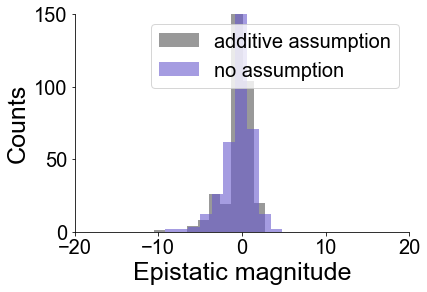

Mean epistatic magnitude with additive assumption:  0.9665839378097912  +/-  1.3397496483304494
Mean epistatic magnitude without additive assumption:  1.263262045494334  +/-  1.3429522746821736


In [115]:
## plot histogram of additive epitasis and no assumption epistasis

## add_magnitude = ensemble only
plt.hist(df12.add_magnitude, color = 'black', alpha = 0.4, label = 'additive assumption', bins = 10)
## magnitude = within-conformation + ensemble 
plt.hist(df12.magnitude, color = 'slateblue', alpha = 0.6, label = 'no assumption', bins = 10)
plt.legend()
plt.xlabel('Epistatic magnitude')
plt.ylabel('Counts')
plt.ylim(0,150)
plt.xlim(-20,20)
plt.savefig(cwd + '/fig-6j-distributions.svg')
plt.show()


### how much higher is the magnitude of the no assumption dataset vs additive assumption dataset?
## mean epistasis for additive vs non-additive 
print('Mean epistatic magnitude with additive assumption: ', np.mean(np.abs(df12.add_magnitude)), ' +/- ', np.std(np.abs(df12.add_magnitude)))
print('Mean epistatic magnitude without additive assumption: ', np.mean(np.abs(df12.magnitude)),  ' +/- ', np.std(np.abs(df12.magnitude)))

## Calculate epistasis in stability for each conformation

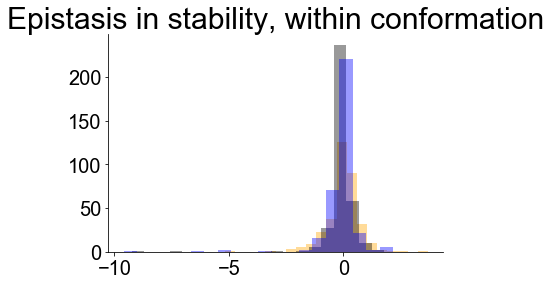

fraction of pairs with intramolecular epistasis in dGapo:  0.29651162790697677
fraction of pairs with intramolecular epistasis in dGca:  0.10755813953488372
fraction of pairs with intramolecular epistasis in dGcapep:  0.13662790697674418


In [116]:
## make array for additive assumption
apo_dG_add = apo_dG_copy[mut12_indices]
ca_dG_add = ca_dG_copy[mut12_indices]
capep_dG_add = capep_dG_copy[mut12_indices]

## make array for not additive assumption
apo_dG_not = copy.deepcopy(apo_dG_add)
ca_dG_not = copy.deepcopy(ca_dG_add)
capep_dG_not = copy.deepcopy(capep_dG_add)


## make a dataframe with all info
df_eff_12 = pd.DataFrame({'mut1': muts1, 'mut2': muts2,
                          'apo_wt': [G_APO]*len(muts1),
                          'ca_wt': [G_CA]*len(muts1), 'capep_wt': [G_CAPEP]*len(muts1), 
                          'apo_m1': apo_dG_not[:,0],
                          'apo_m2': apo_dG_not[:,1], 'apo_m12': apo_dG_not[:,2],
                          'ca_m1': ca_dG_not[:,0], 'ca_m2': ca_dG_not[:,1], 'ca_m12': ca_dG_not[:,2],
                           'capep_m1': capep_dG_not[:,0], 'capep_m2': capep_dG_not[:,1], 'capep_m12': capep_dG_not[:,2]},
                    index = [mut12_indices])


## expected from single effects = eff_m1 + eff_m2
## compare this to observed to get epistasis in stability of each conformation
df_eff_12['apo_ab'] = df_eff_12['apo_m1'] + df_eff_12['apo_m2']
df_eff_12['apo_epi'] = df_eff_12['apo_m12'] - df_eff_12['apo_ab']

df_eff_12['ca_ab'] = df_eff_12['ca_m1'] + df_eff_12['ca_m2']
df_eff_12['ca_epi'] = df_eff_12['ca_m12'] - df_eff_12['ca_ab']


df_eff_12['capep_ab'] = df_eff_12['capep_m1'] + df_eff_12['capep_m2']
df_eff_12['capep_epi'] = df_eff_12['capep_m12'] - df_eff_12['capep_ab']

plt.hist(df_eff_12.apo_epi, color = 'orange', alpha = 0.4, bins = 20, label = 'apo')
plt.hist(df_eff_12.ca_epi, color = 'black', alpha = 0.4, bins = 20, label = 'ca')
plt.hist(df_eff_12.capep_epi, color = 'blue', alpha = 0.4, bins = 20, label = 'capep')
plt.title('Epistasis in stability, within conformation')
#plt.xlim(-20,10)
plt.show()



print('fraction of pairs with intramolecular epistasis in dGapo: ', len(df_eff_12[np.abs(df_eff_12.apo_epi) >= 0.6])/len(df_eff_12))
print('fraction of pairs with intramolecular epistasis in dGca: ', len(df_eff_12[np.abs(df_eff_12.ca_epi) >= 0.6])/len(df_eff_12))
print('fraction of pairs with intramolecular epistasis in dGcapep: ', len(df_eff_12[np.abs(df_eff_12.capep_epi) >= 0.6])/len(df_eff_12))

# Supplementary Figure 1

# What does changing $G_{ca} = 10$ kcal/mol do to epistasis values?


For all calculations above we assumed:
+ G_APO =  0 (apo form is favored )
+ G_CA  =    10 (ca form is destabilized by 10 kcal/mol (@ calcium Kd))
+ G_CAPEP =  20 (capep form destabilized by 20 kcal/mol (@ calcium Kd and peptide Kd))


What happens to epistasis values if we increase/decrease $G_{ca}$?

## Define new $G_{ca}$ values

In [117]:
# define increased/decreased G_Ca values
G_CA_inc = 15
G_CA_dec = 5
# use broader range of mu_ca values
mu_ca_broad = np.arange(-20,20,1)

## calculate maximum magnitude of epistasis for new $G_{ca}$ values

In [118]:
#################################################################################################################
## Calculate maximum magnitude of epistasis for G_ca = 15 kcal/mol
#################################################################################################################
max_mag_inc = np.zeros(len(apo_dG_mean), dtype = np.float)
max_mag_dec = np.zeros(len(apo_dG_mean), dtype = np.float)

for i in range(len(apo_dG_mean)):
    
    
    #################################################################################################################
    ## Calculate maximum magnitude of epistasis for G_ca = 15 kcal/mol
    #################################################################################################################
    mag_i, sign1, sign2 = epistasis_vs_ca(apo_dG_mean[i,:],
                                        ca_dG_mean[i,:],
                                        capep_dG_mean[i,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA_inc,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=mu_ca_broad,
                                        additive_in_states=True,
                                        beta=BETA)
    
    # Index of maximum epistasis over this [Ca] range
    max_index = np.argmax(np.abs(mag_i))    
    max_mag_inc[i] = mag_i[max_index]
    
    #################################################################################################################
    ## Calculate maximum magnitude of epistasis for G_ca = 5 kcal/mol
    #################################################################################################################
    mag_d, sign1, sign2 = epistasis_vs_ca(apo_dG_mean[i,:],
                                        ca_dG_mean[i,:],
                                        capep_dG_mean[i,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA_dec,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=mu_ca_broad,
                                        additive_in_states=True,
                                        beta=BETA)
               
    # Index of maximum epistasis over this [Ca] range
    max_index = np.argmax(np.abs(mag_d))               
    max_mag_dec[i] = mag_d[max_index]
    
    
   
#################################################################################################################
## Compare fraction of pairs with magnitude >= 1 kT at G_ca = 15, 5, and 10 kcal/mol
#################################################################################################################
print('Fraction of pairs with epistatic magnitude >= 0.6 kcal/mol when G_ca = 15 kcal/mol: ', len(max_mag_inc[np.abs(max_mag_inc) >= 0.6])/len(apo_dG_mean))
print('Fraction of pairs with epistatic magnitude >= 0.6 kcal/mol when G_ca = 5 kcal/mol: ', len(max_mag_dec[np.abs(max_mag_dec) >= 0.6])/len(apo_dG_mean))
print('Fraction of pairs with epistatic magnitude >= 0.6 kcal/mol when G_ca = 10 kcal/mol: ', len(max_mag[np.abs(max_mag) >= 0.6])/len(apo_dG_mean))
                   

/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in true_divide
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in true_divide
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in true_divide


Fraction of pairs with epistatic magnitude >= 0.6 kcal/mol when G_ca = 15 kcal/mol:  0.40109881897358335
Fraction of pairs with epistatic magnitude >= 0.6 kcal/mol when G_ca = 5 kcal/mol:  0.3856165637359142
Fraction of pairs with epistatic magnitude >= 0.6 kcal/mol when G_ca = 10 kcal/mol:  0.46785108688790406


## Compare M85K/F145R, L109I/F145R, F78A/F145R epistasis vs mu_ca curves at different $G_{ca}$ values



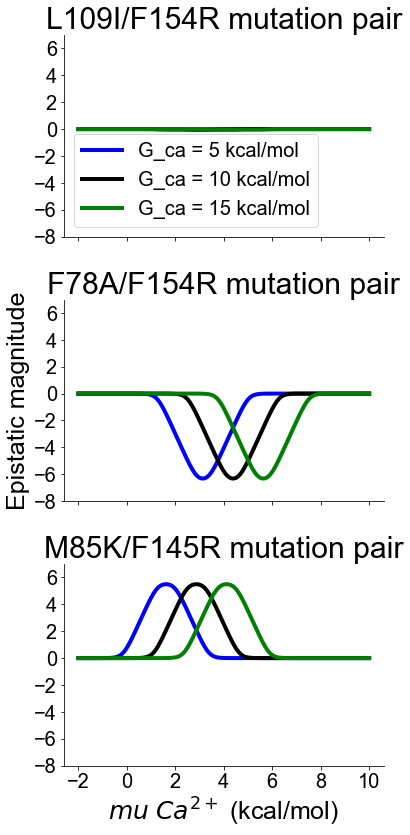

In [132]:
#################################################################################################################
## Look at how epistasis magnitude vs mu_ca_range changes as we inc/dec G_ca 
## for the L109I/F145R mutation pair
#################################################################################################################
#################################################################################################################
# what happens to epistasis as a funtion of mu_ca for l109i/f145r pair if we increase G_ca to 15 kcal/mol?
#################################################################################################################
mag_inc_l109i, sign1, sign2 = epistasis_vs_ca(apo_dG_mean[n_idx,:],
                                        ca_dG_mean[n_idx,:],
                                        capep_dG_mean[n_idx,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA_inc,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)


#################################################################################################################
# what happens to epistasis as a funtion of mu_ca for L109I/f145r pair if we deccrease G_ca to 5 kcal/mol?
#################################################################################################################
mag_dec_l109i, sign1, sign2 = epistasis_vs_ca(apo_dG_mean[n_idx,:],
                                        ca_dG_mean[n_idx,:],
                                        capep_dG_mean[n_idx,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA_dec,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)

#################################################################################################################
# no effect on G_ca (i.e. G_ca = 10 kcal/mol)
#################################################################################################################
mag_norm_l109i, sign1, sign2 = epistasis_vs_ca(apo_dG_mean[n_idx,:],
                                        ca_dG_mean[n_idx,:],
                                        capep_dG_mean[n_idx,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)

#################################################################################################################
## plot!
#################################################################################################################
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex = True, figsize = (6,12))

ax1.plot(MU_CA_RANGE, mag_dec_l109i, label = 'G_ca = 5 kcal/mol',
         linewidth = 4, color = 'blue')
ax1.plot(MU_CA_RANGE, mag_norm_l109i, label = 'G_ca = 10 kcal/mol',
         linewidth = 4, color = 'black')
ax1.plot(MU_CA_RANGE, mag_inc_l109i, label = 'G_ca = 15 kcal/mol', 
         linewidth = 4, color = 'green')
ax1.legend()

ax1.set_title('L109I/F154R mutation pair')
ax1.set_ylim(-6,7)


#################################################################################################################
## Look at how epistasis magnitude vs mu_ca_range changes as we inc/dec G_ca 
## for the F78A/F145R mutation pair
#################################################################################################################
#################################################################################################################
# what happens to epistasis as a funtion of mu_ca for f78a/f145r pair if we increase G_ca to 15 kcal/mol?
#################################################################################################################
mag_inc_f78a, sign1, sign2 = epistasis_vs_ca(apo_dG_mean[m_idx,:],
                                        ca_dG_mean[m_idx,:],
                                        capep_dG_mean[m_idx,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA_inc,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)


#################################################################################################################
# what happens to epistasis as a funtion of mu_ca for F78A/f145r pair if we deccrease G_ca to 5 kcal/mol?
#################################################################################################################
mag_dec_f78a, sign1, sign2 = epistasis_vs_ca(apo_dG_mean[m_idx,:],
                                        ca_dG_mean[m_idx,:],
                                        capep_dG_mean[m_idx,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA_dec,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)

#################################################################################################################
# no effect on G_ca (i.e. G_ca = 10 kcal/mol)
#################################################################################################################
mag_norm_f78a, sign1, sign2 = epistasis_vs_ca(apo_dG_mean[m_idx,:],
                                        ca_dG_mean[m_idx,:],
                                        capep_dG_mean[m_idx,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)

#################################################################################################################
## plot!
#################################################################################################################




ax2.plot(MU_CA_RANGE, mag_dec_f78a, label = 'G_ca = 5 kcal/mol',
         linewidth = 4, color = 'blue')
ax2.plot(MU_CA_RANGE, mag_norm_f78a, label = 'G_ca = 10 kcal/mol',
         linewidth = 4, color = 'black')
ax2.plot(MU_CA_RANGE, mag_inc_f78a, label = 'G_ca = 15 kcal/mol', 
         linewidth = 4, color = 'green')

ax2.set_ylabel('Epistatic magnitude')
ax2.set_title('F78A/F154R mutation pair')

ax2.set_ylim(-6,7)


#################################################################################################################
## Look at how epistasis magnitude vs mu_ca_range changes as we inc/dec G_ca 
## for the M85K/F145R mutation pair
#################################################################################################################
#################################################################################################################
# what happens to epistasis as a funtion of mu_ca for m85k/f145r pair if we increase G_ca to 15 kcal/mol?
#################################################################################################################
mag_inc_m85k, sign1, sign2 = epistasis_vs_ca(apo_dG_mean[s_idx,:],
                                        ca_dG_mean[s_idx,:],
                                        capep_dG_mean[s_idx,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA_inc,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)


#################################################################################################################
# what happens to epistasis as a funtion of mu_ca for m85k/f145r pair if we deccrease G_ca to 5 kcal/mol?
#################################################################################################################
mag_dec_m85k, sign1, sign2 = epistasis_vs_ca(apo_dG_mean[s_idx,:],
                                        ca_dG_mean[s_idx,:],
                                        capep_dG_mean[s_idx,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA_dec,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)

#################################################################################################################
# no effect on G_ca (i.e. G_ca = 10 kcal/mol)
#################################################################################################################
mag_norm_m85k, sign1, sign2 = epistasis_vs_ca(apo_dG_mean[s_idx,:],
                                        ca_dG_mean[s_idx,:],
                                        capep_dG_mean[s_idx,:],
                                        G_apo=G_APO,
                                        G_ca=G_CA,
                                        G_capep=G_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)

#################################################################################################################
## plot!
#################################################################################################################

ax3.plot(MU_CA_RANGE, mag_dec_m85k, label = 'G_ca = 5 kcal/mol',
         linewidth = 4, color = 'blue')
ax3.plot(MU_CA_RANGE, mag_norm_m85k, label = 'G_ca = 10 kcal/mol',
         linewidth = 4, color = 'black')
ax3.plot(MU_CA_RANGE, mag_inc_m85k, label = 'G_ca = 15 kcal/mol', 
         linewidth = 4, color = 'green')

ax3.set_title('M85K/F145R mutation pair')
ax3.set_xlabel('$mu$ $Ca^{2+}$ (kcal/mol)')
ax3.set_ylim(-6,7)

## change tick frequency 
ax1.set_xticks(np.arange(-2,10.1, 2))
ax1.set_yticks(np.arange(-8,7.1, 2))
ax2.set_yticks(np.arange(-8,7.1, 2))
ax3.set_yticks(np.arange(-8,7.1, 2))



plt.tight_layout()
plt.savefig(cwd + '/supplementary-fig-1.svg')

